<a href="https://colab.research.google.com/github/danielsoy/ALOCC-CVPR2018/blob/master/malaria_botelladetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive

In [19]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
import cv2

img = cv2.imread("/content/drive/MyDrive/malaria_botellas/Parasitized/anomalo1.jpg")
img.shape

(480, 640, 3)

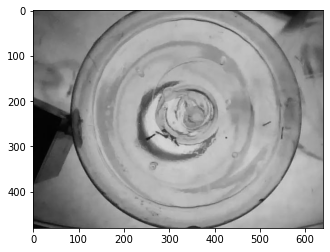

In [107]:
import matplotlib.pyplot as plt

plt.imshow(img)

In [108]:
img_dir = "/content/drive/MyDrive/malaria_botellas"



In [109]:
import tensorflow as tf

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.,                                                                                                                   
                                                           #rotation_range=0.2,  "estos 4 hacen preprocesado"
                                                           #width_shift_range=0.2,
                                                           #height_shift_range=0.2,
                                                           #zoom_range = 0.2, 
                                                           horizontal_flip=True,
                                                           validation_split = 0.25
                                                            )
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.,
                                                          validation_split = 0.25
                                                          )

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.,
                                                          validation_split = 0.50
                                                          )



In [129]:
train_data = train_gen.flow_from_directory(img_dir,
                                           target_size = (224,224),
                                           class_mode = "categorical",
                                           batch_size = 32,
                                           classes = ["Parasitized","Uninfected"],
                                           seed = 42,
                                           subset = "training"                                           
                                           )

test_data = test_gen.flow_from_directory(img_dir,
                                         target_size = (224,224),
                                         class_mode = "categorical",
                                         classes = ["Parasitized","Uninfected"],
                                         batch_size = 32,
                                         seed = 42,
                                         subset = "validation"
                                         )

val_data = val_gen.flow_from_directory(img_dir,
                                         target_size = (224,224),
                                         class_mode = "categorical",
                                         classes = ["Paraval","Unival"],
                                         batch_size = 16,
                                         seed = 42,
                                         subset = "validation"
                                         )

Found 688 images belonging to 2 classes.
Found 228 images belonging to 2 classes.
Found 70 images belonging to 2 classes.


In [130]:
class_labels = list(val_data.class_indices.keys())

class_labels

['Paraval', 'Unival']

In [131]:
image,label = train_data.next()
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 2)


IndexError: ignored

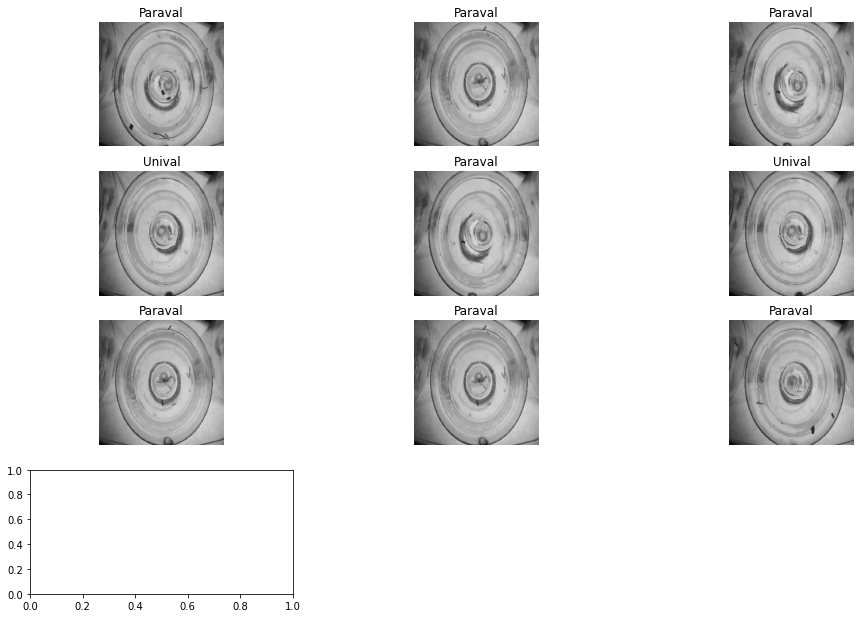

In [132]:
# visualizing the train data

import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(16,16))

for i in range(18):

  image,label = val_data.next()

  plt.subplot(6,3,i+1)
  plt.imshow(image[i])
  plt.title(class_labels[tf.argmax(label[i])])
  plt.axis("off")


In [115]:
#building a CNN model
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
                             layers.Conv2D(filters=64, kernel_size= 2, activation="relu", input_shape=(224,224,3)),
                             layers.MaxPooling2D(pool_size= 2),

                             layers.Conv2D(filters= 64, kernel_size= 2, activation="relu"),
                             layers.MaxPooling2D(pool_size= 2),

                             layers.Conv2D(filters= 64, kernel_size= 2, activation= "relu"),
                             layers.MaxPooling2D(pool_size = 2),


                             layers.Flatten(),

                             layers.Dense(128, activation= "relu"),
                             layers.Dropout(0.5),
                             layers.Dense(2, activation="softmax"),
])


In [116]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 223, 223, 64)      832       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 110, 110, 64)      16448     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 54, 54, 64)        16448     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 27, 27, 64)      

In [117]:
# compiling the model

model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [118]:
# fitting data to the model
model.fit(train_data,
          epochs = 50,
          steps_per_epoch = len(train_data),
          validation_data = test_data,
          validation_steps = len(test_data)
          )

Epoch 1/50
22/22 [==============================] - 8s 351ms/step - loss: 0.9267 - accuracy: 0.4927 - val_loss: 0.6933 - val_accuracy: 0.4868
Epoch 2/50
22/22 [==============================] - 7s 332ms/step - loss: 0.6935 - accuracy: 0.5116 - val_loss: 0.6878 - val_accuracy: 0.5132
Epoch 3/50
22/22 [==============================] - 7s 325ms/step - loss: 0.6834 - accuracy: 0.5523 - val_loss: 0.6628 - val_accuracy: 0.5132
Epoch 4/50
22/22 [==============================] - 7s 328ms/step - loss: 0.6003 - accuracy: 0.6497 - val_loss: 0.4048 - val_accuracy: 0.8640
Epoch 5/50
22/22 [==============================] - 7s 327ms/step - loss: 0.3696 - accuracy: 0.8561 - val_loss: 0.1724 - val_accuracy: 1.0000
Epoch 6/50
22/22 [==============================] - 8s 375ms/step - loss: 0.1473 - accuracy: 0.9433 - val_loss: 0.2568 - val_accuracy: 0.8289
Epoch 7/50
22/22 [==============================] - 7s 335ms/step - loss: 0.0914 - accuracy: 0.9724 - val_loss: 0.0211 - val_accuracy: 1.0000
Epoch 

In [134]:
model_evaluation = model.evaluate(val_data) # poner aca train_data, test_data, o val_data para evaluar inferencia con data de train, test o validacion.

5/5 [==============================] - 1s 152ms/step - loss: 2.6968e-04 - accuracy: 1.0000


In [135]:
print(f"Model Accuracy: {model_evaluation[1] * 100:.2f} %")

Model Accuracy: 100.00 %


IndexError: ignored

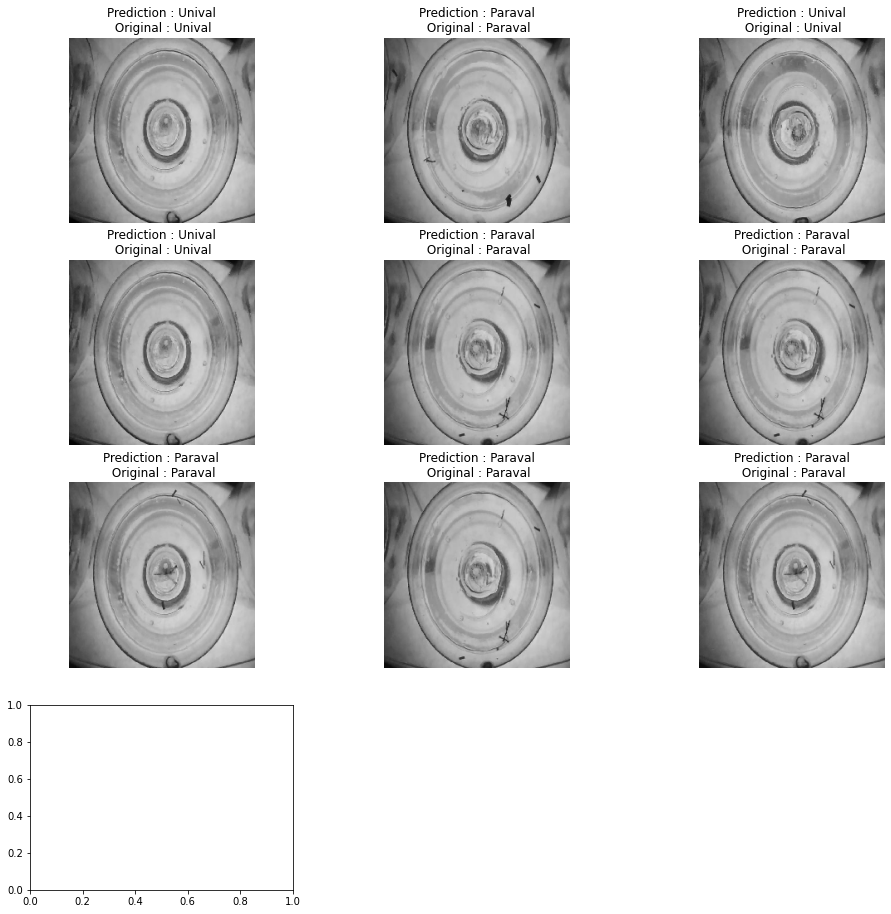

In [136]:
# visualizing the train data

import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(16,16))

for i in range(18):

  image,label = val_data.next()

  model_pred = model.predict(image)

  plt.subplot(6,3,i+1)
  plt.imshow(image[i])
  plt.title(f"Prediction : {class_labels[tf.argmax(model_pred[i])]}\n Original : {class_labels[tf.argmax(label[i])]}")
  plt.subplots_adjust(top = 1.25)
  plt.axis("off")